# Table of Contents
 <p><div class="lev1"><a href="#Derive-scaling"><span class="toc-item-num">1&nbsp;&nbsp;</span>Derive scaling</a></div><div class="lev2"><a href="#Compute-statistics"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Compute statistics</a></div><div class="lev3"><a href="#Decompose-bias-into-its-contributions-from-qvstar-and-omega-(scaling-#3)"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Decompose bias into its contributions from qvstar and omega (scaling #3)</a></div><div class="lev2"><a href="#Decompose-the-variance"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Decompose the variance</a></div><div class="lev3"><a href="#Decompose-Variance-into-its-contributions-from-qvstar-and-omega-(scaling-#3)"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Decompose Variance into its contributions from qvstar and omega (scaling #3)</a></div><div class="lev3"><a href="#Decompose-variance-into-its-contributions-from-T-and-omega-(ignore-variability-in-pressure)"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Decompose variance into its contributions from T and omega (ignore variability in pressure)</a></div>

In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
%autoreload 2

print("-- loading modules")
print()

import numpy as np
import numpy.ma as ma
import dask.array as da
import matplotlib.pyplot as plt
import datetime as dt
import sys,os,glob
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
moduledir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])
print()
## Load own libraries
from environmentAndDirectories import *
from importingData import *
from scalingApproximations import *
from slicingAndSubsetting import *
from thermoConstants import L_v,R_v
from plotMaps import *
from plot1DInvLog import *
from statisticalDistributions import *

-- loading modules

Own modules available: ['CAMsettings', 'daskOptions', 'environmentAndDirectories', 'importingData', 'physicalConstants', 'plot1DInvLog', 'plotMaps', 'scalingApproximations', 'slicingAndSubsetting', 'statisticalDistributions', 'thermoConstants', 'thermoFunctions']



In [3]:
print("-- define global variables")
print()

print("- choosing options:")
compset = 'FSPCAMm_AMIP'
experiment = 'piControl'
subset = 'tropics'
time_stride = 'day'
daskarray = True
dates = ('185005010000','185005020000')

for v in ['compset','experiment','subset','time_stride',\
          'daskarray','dates']:
    print("%s:"%v,getattr(thismodule,v))

## Define percentile values
Q_IL_ext = np.array([90.0, 92.0567, 93.6904, 94.9881, 96.0189, 96.8377, 97.4881, 98.0047, 98.4151, 98.7411,
        99.0, 99.2057, 99.369, 99.4988, 99.6019, 99.6838, 99.7488, 99.8005, 99.8415, 99.8741,
        99.9, 99.9206, 99.9369, 99.9499, 99.9602, 99.9684, 99.9749, 99.98, 99.9842, 99.9874,
        99.99, 99.9921, 99.9937, 99.995, 99.996, 99.9968, 99.9975, 99.998, 99.9984, 99.9987])
Q_IL_ext_colorbar = np.array([90.0, 92.0567, 93.6904, 94.9881, 96.0189, 96.8377, 97.4881, 98.0047, 98.4151, 98.7411,
        99.0, 99.2057, 99.369, 99.4988, 99.6019, 99.6838, 99.7488, 99.8005, 99.8415, 99.8741,
        99.9, 99.9206, 99.9369, 99.9499, 99.9602, 99.9684, 99.9749, 99.98, 99.9842, 99.9874,
        99.99, 99.9921, 99.9937, 99.995, 99.996, 99.9968, 99.9975, 99.998, 99.9984, 99.9987,99.999])
Qs = [90.,96.8377,99.,99.6838,99.9,99.9684,99.99,99.9968]
Q_ids = ['90.0','96.8377','99.0','99.6838','99.9','99.9684','99.99','99.9968']

print()

-- define global variables

- choosing options:
compset: FSPCAMm_AMIP
experiment: piControl
subset: tropics
time_stride: day
daskarray: True
dates: ('185005010000', '185005020000')



In [4]:
print("-- load environment")
print()

historyFilesSettings = getCAMHistoryFilesSettings()

inputdir, inputdir_processed_day, inputdir_processed_1hr, inputdir_results, inputdir_fx = \
    getInputDirectories(compset,experiment)
    
q_id = 'Q'
spechum = getValues(q_id,compset,subset,experiment,time_stride,daskarray=daskarray,dates=dates)
omega_id = 'OMEGA'
omega = getValues(omega_id,compset,subset,experiment,time_stride,daskarray=daskarray,dates=dates)
pr_id = 'PRECT'
pr = getValues(pr_id,compset,subset,experiment,time_stride,daskarray=daskarray,dates=dates)
ts_id = 'TS'
ts = getValues(ts_id,compset,subset,experiment,time_stride,daskarray=daskarray,dates=dates)
ta_id = 'T'
ta = getValues(ta_id,compset,subset,experiment,time_stride,daskarray=daskarray,dates=dates)
relhum_id = 'RELHUM'
relhum = getValues(relhum_id,compset,subset,experiment,time_stride,daskarray=daskarray,dates=dates)

print()

-- load environment

Importing Q from 24 history files between 1850-05-01-00000 and 1850-05-01-82800
Importing OMEGA from 24 history files between 1850-05-01-00000 and 1850-05-01-82800
Importing PRECT from 24 history files between 1850-05-01-00000 and 1850-05-01-82800
Importing TS from 24 history files between 1850-05-01-00000 and 1850-05-01-82800
Importing T from 24 history files between 1850-05-01-00000 and 1850-05-01-82800
Importing RELHUM from 24 history files between 1850-05-01-00000 and 1850-05-01-82800



In [5]:
## Get longitude, latitude and landmask

print("-- load geographic data")

fh = Dataset(os.path.join(inputdir_fx,'landmask_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc'))
lon1D = fh.variables['lon'][:]
lat1D = fh.variables['lat'][:]
lon2D, lat2D = np.meshgrid(lon1D,lat1D)
lon2D = da.from_array(lon2D,chunks=lon2D.shape)
lat2D = da.from_array(lat2D,chunks=lat2D.shape)

landmask = fh.variables['landmask']

print()

-- load geographic data



In [6]:
print("-- load surface pressure")

input_lev_file = os.path.join(inputdir_fx,'lev_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc')
computeP = getPressureCoordinateFunction(input_lev_file)

ps_varid = 'PS'
ps = getValues(ps_varid,compset,subset,experiment,time_stride,daskarray=daskarray,dates=dates)
pres = computeP(ps)
cn = getArrayType(pres)
print()

-- load surface pressure
Importing PS from 24 history files between 1850-05-01-00000 and 1850-05-01-82800



# Derive scaling

In [7]:
print("-- compute (percentile-wise and pointwise) scaling approximation")
print()

-- compute (percentile-wise and pointwise) scaling approximation



In [8]:
%%time
print("compute 2D surfaces of predictor variables")
p_500 = 50000; levdim=1
# p_925 = 92500
omega_500 = isobaricSurface(omega,pres,p_ref=p_500,levdim=levdim)
# ta_925 = isobaricSurface(ta,pres,p_ref=p_925,levdim=levdim)
# qvstar_925 = saturationSpecificHumidity(ta_925,p_925)
qvstar_s = saturationSpecificHumidity(ts,ps)

compute 2D surfaces of predictor variables

CPU times: user 866 ms, sys: 348 ms, total: 1.21 s
Wall time: 797 ms


In [10]:
%%time
print()
print("Compute ranks and ranks locations")

n_pts = pr.size
Q_IL = getInvLogRanks(n_pts,fill_last_decade=True)
i_Q = indexOfRank(99.9,Q_IL)
iQ_slice = slice(i_Q-5,i_Q+5)
ranks, centers, bins = computePercentilesAndBinsFromRanks(pr.flatten(),Q_IL)

rank_locations= {}
for rank in Q_IL:
    rank_id  = "%2.4f"%rank
    print(rank_id,end=' ')
    rank_locations[rank_id] = getRankLocations(rank,pr,ranks,bins,rank_locations)



Compute ranks and ranks locations
0.0000 20.5672 36.9043 49.8813 60.1893 68.3772 74.8811 80.0474 84.1511 87.4107 90.0000 92.0567 93.6904 94.9881 96.0189 96.8377 97.4881 98.0047 98.4151 98.7411 99.0000 99.2057 99.3690 99.4988 99.6019 99.6838 99.7488 99.8005 99.8415 99.8741 99.9000 99.9206 99.9369 99.9499 99.9602 99.9684 99.9749 99.9800 99.9842 99.9874 99.9900 CPU times: user 86.8 ms, sys: 15.3 ms, total: 102 ms
Wall time: 96 ms


In [11]:
print()
print("compute sample size in each bin")
N_prQ = np.array(list(map(lambda x: sampleSizeAtYRank(x,pr,rank_locations=rank_locations),ranks)))
print(N_prQ.sum(),pr.size)


compute sample size in each bin
14159 18432


In [12]:
%%time
print()
print("compute pointwise scaling")
eps, pr_sc_vQ = computeScalingOmegaQAtAllRanks(ranks,omega_500,qvstar_s,pr,ranks_ref=Q_IL[iQ_slice],
                                                  bins=bins,rank_locations=rank_locations)
pr_sc = singleLevelScalingFromOmegaQ(omega_500,qvstar_s,efficiency=eps)
print("eps =",eps)


compute pointwise scaling
eps = 0.000534980294616
CPU times: user 14.5 s, sys: 2.89 s, total: 17.4 s
Wall time: 15 s


## Compute statistics

In [14]:
print("-- compute statistics")
print()

-- compute statistics



In [18]:
%%time
print("mean of scaling in pr bins")
pr_sc_prQ = np.array(list(map(lambda x: meanXAtYRank(x,pr_sc,pr,rank_locations=rank_locations),ranks)))

mean of scaling in pr bins
CPU times: user 7.82 s, sys: 1.65 s, total: 9.47 s
Wall time: 7.98 s


In [19]:
%%time
print()
print("interquartile and 90% ranges")
ranks_I90 = (5,95)
ranks_IQR = (25,75)

pr_sc_I90 = np.vstack(list(map(lambda x: XPercentilesAtYRank(x,pr_sc,ranks_I90,pr,
                                                                     rank_locations_X=rank_locations),ranks)))
pr_sc_IQR = np.vstack(list(map(lambda x: XPercentilesAtYRank(x,pr_sc,ranks_IQR,pr,
                                                                     rank_locations_X=rank_locations),ranks)))



interquartile and 90% ranges
CPU times: user 6.69 s, sys: 1.44 s, total: 8.14 s
Wall time: 6.82 s


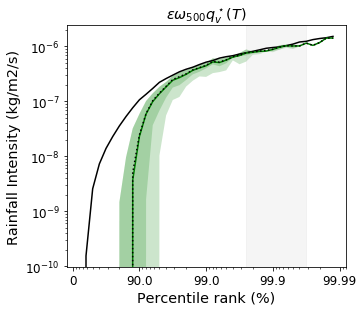

In [176]:
print()
print("- plot PDF with scaling and variability")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))

ax.set_yscale('log')

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks,i_Q_lims,alpha=0.15,transformX=False)
# 90% confidence interval for pointwise scaling 2
subplotYShadingRanksILog(ax,ranks,[pr_sc_I90[:,0],pr_sc_IQR[:,1]],col='green',transformX=False)
# Interquartile range for pointwise scaling 2
subplotYShadingRanksILog(ax,ranks,[pr_sc_IQR[:,0],pr_sc_IQR[:,1]],col='green',transformX=False)
# Mean of pointwise scaling 2
subplotRanksILog(ax,ranks,[centers,pr_sc_prQ,pr_sc_vQ],col=['k','green','k'],ltype=['-','-',':'],transformX=True)

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel('Rainfall Intensity (kg/m2/s)')
ax.set_title(r'$\varepsilon\omega_{500}q_v^\star(T)$')

plt.show()

print()

### Decompose bias into its contributions from qvstar and omega (scaling #3)

In [21]:
print("-- decompose bias into qvstar and omega contributions")
print()

-- decompose bias into qvstar and omega contributions



In [25]:
%%time
print()
print("Q-mean terms")
qvstar_s_prQ = np.array(list(map(lambda x: meanXAtYRank(x,qvstar_s,pr,rank_locations=rank_locations),ranks)))
omega_500_prQ = np.array(list(map(lambda x: meanXAtYRank(x,omega_500,pr,rank_locations=rank_locations),ranks)))


Q-mean terms
CPU times: user 10.7 s, sys: 2.19 s, total: 12.9 s
Wall time: 10.9 s


In [26]:
%%time
print()
print("Compute bias")
bias_sc = (pr_sc_prQ - pr_sc_vQ)/pr_sc_prQ
print(np.nanmean(bias_sc[iQ_slice]))


Compute bias
-0.00627489038756
CPU times: user 691 µs, sys: 473 µs, total: 1.16 ms
Wall time: 707 µs


In [27]:
%%time
print()
print("covariance term")
cov_qvstar_s_omega_500_prQ = np.array(list(map(lambda x: covAtYRank(x,qvstar_s,omega_500,pr,
                                                                           rank_locations=rank_locations),ranks)))


Compute covariance term
CPU times: user 4.28 s, sys: 866 ms, total: 5.15 s
Wall time: 4.43 s


In [29]:
print()
print("contribution")
contrib_b_cov_qvstar_s_omega_500 = cov_qvstar_s_omega_500_prQ*(-eps/gg)/pr_sc_prQ


contribution



- plot bias and corresponding contributions


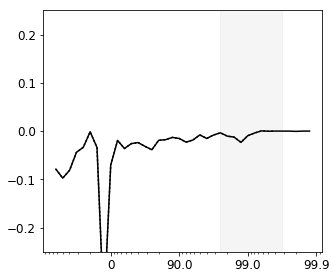


CPU times: user 296 ms, sys: 6.62 ms, total: 303 ms
Wall time: 305 ms


In [30]:
%%time
print()
print("- plot bias and corresponding contributions")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))
ax.set_ylim((-.25,.25))

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks,i_Q_lims,alpha=0.15,transformX=False)

subplotRanksILog(ax,ranks,
                 bias_sc,
                 col='k',ltype='-',transformX=False)

subplotRanksILog(ax,ranks,
                 contrib_b_cov_qvstar_s_omega_500,
                 col='k',ltype=':',transformX=True)

plt.show()
print()

## Decompose the variance

### Decompose Variance into its contributions from qvstar and omega (scaling #3)

In [31]:
print("-- decompose variance into qvstar and omega contributions")

-- decompose variance into qvstar and omega contributions


In [32]:
%%time 
print()
print("Compute the variance in pr")
var_pr_sc_prQ = np.array(list(map(lambda x: varXAtYRank(x,pr_sc,pr,rank_locations=rank_locations),ranks)))


Compute the variance in pr
CPU times: user 7.4 s, sys: 1.56 s, total: 8.95 s
Wall time: 7.46 s


In [34]:
print()
print("normalized variability")
norm_var_pr_sc_prQ = var_pr_sc_prQ/(pr_sc_prQ**2)
print(np.nanmean(norm_var_pr_sc_prQ[iQ_slice]))


normalized variability
0.0101180667322


In [33]:
%%time
print()
print("compute variability terms")
var_qvstar_s_prQ = np.array(list(map(lambda x: varXAtYRank(x,qvstar_s,pr,rank_locations=rank_locations),
                                     ranks)))
var_omega_500_prQ = np.array(list(map(lambda x: varXAtYRank(x,omega_500,pr,rank_locations=rank_locations),
                                      ranks)))
cov_qvstar_s_omega_500_prQ = np.array(list(map(lambda x: covAtYRank(x,qvstar_s,omega_500,
                                                                           pr,rank_locations=rank_locations),
                                               ranks)))
cov_qvstar_s_2_omega_500_2_prQ = np.array(list(map(lambda x: covAtYRank(x,qvstar_s**2,omega_500**2,pr,
                                                                               rank_locations=rank_locations),
                                                   ranks)))
print()


compute variability terms

CPU times: user 18.6 s, sys: 3.6 s, total: 22.2 s
Wall time: 19.3 s


In [36]:
print()
print("normalized contributions, expanded terms")

a_v = (eps/gg)**2
contrib_covX2Y2 = a_v*cov_qvstar_s_2_omega_500_2_prQ/(pr_sc_prQ**2)
contrib_varX = a_v*(omega_500_prQ**2)*var_qvstar_s_prQ/(pr_sc_prQ**2)
contrib_varY = a_v*(qvstar_s_prQ**2)*var_omega_500_prQ/(pr_sc_prQ**2)
contrib_varXvarY = a_v*var_qvstar_s_prQ*var_omega_500_prQ/(pr_sc_prQ**2)
contrib_cov2XY = -a_v*(cov_qvstar_s_omega_500_prQ**2)/(pr_sc_prQ**2)
contrib_covXY = -a_v*2*qvstar_s_prQ*omega_500_prQ*cov_qvstar_s_omega_500_prQ/(pr_sc_prQ**2)
contrib_sum = contrib_covX2Y2 + contrib_varX + contrib_varY + contrib_varXvarY + contrib_cov2XY + contrib_covXY

print(np.nanmean(contrib_varX[iQ_slice]),np.nanmean(contrib_varY[iQ_slice]),
      np.nanmean(contrib_varXvarY[iQ_slice]),
      np.nanmean(contrib_cov2XY[iQ_slice]),np.nanmean(contrib_covXY[iQ_slice]),
      np.nanmean(contrib_sum[iQ_slice]))
print()


normalized contributions, expanded terms
0.00795293520723 0.0163808857407 0.000168275312321 -0.000102736340454 0.0141496735422 0.0101180667322




- plot variance and corresponding contributions


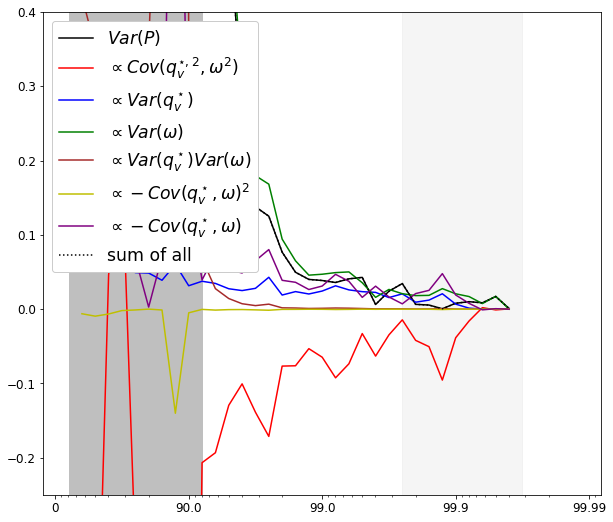


CPU times: user 874 ms, sys: 19.8 ms, total: 894 ms
Wall time: 900 ms


In [37]:
%%time
print()
print("> plot variance and corresponding contributions")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(10,9))
ax.set_ylim((-.25,.4))

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks,i_Q_lims,alpha=0.15,transformX=False)

subplotRanksILog(ax,ranks,
                 norm_var_pr_sc_prQ,
                 col='k',ltype='-',transformX=False)
subplotRanksILog(ax,ranks,
                 [contrib_covX2Y2,contrib_varX,contrib_varY,contrib_varXvarY,contrib_cov2XY,contrib_covXY,contrib_sum],
                 col=['r','b','g','brown','y','purple','k'],ltype=['-','-','-','-','-','-',':'],transformX=False)

subplotXShadingRanksILog(ax,ranks,(0,10),alpha=1,col='white',transformX=True)

leg = ax.legend([r'$Var(P)$',
                 r'$\propto Cov(q_v^{\star,2},\omega^2)$',
                 r'$\propto Var(q_v^\star)$',
                 r'$\propto Var(\omega)$',
                 r'$\propto Var(q_v^\star)Var(\omega)$',
                 r'$\propto -Cov(q_v^\star,\omega)^2$',
                 r'$\propto -Cov(q_v^\star,\omega)$',
                 r'sum of all'],
                 loc='upper left',
                 fontsize='xx-large')
leg.get_frame().set_alpha(1)

# ax2 = ax.twinx()
# ax2.set_yscale('log')
# subplotRanksILog(ax2,ranks,
#                  N_prQ,
#                  col='gray',ltype='-',transformX=False)
# ax2.tick_params(axis='y', colors='gray')

plt.show()
print()

### Decompose variance into its contributions from T and omega (ignore variability in pressure)

In [38]:
print("-- decompose variance into T and omega contributions")

-- decompose variance into T and omega contributions


In [200]:
print()
print("Q-mean terms")
ts_prQ = np.array(list(map(lambda x: meanXAtYRank(x,ts,pr,rank_locations=rank_locations),ranks)))


Q-mean terms


In [216]:
%%time
print()
print("compute variability terms")
var_ts_prQ = np.array(list(map(lambda x: varXAtYRank(x,ts,pr,rank_locations=rank_locations),Q_IL)))
cov_ts_omega_500_prQ = np.array(list(map(lambda x: covAtYRank(x,ts,omega_500,pr,rank_locations=rank_locations),
                                         ranks)))
cov_ts_omega_500_2_prQ = np.array(list(map(lambda x: covAtYRank(x,ts,omega_500**2,pr,rank_locations=rank_locations),
                                         ranks)))

compute variability terms


In [202]:
print()
print("normalized contributions, expanded terms")

contrib_var_covTomega2 = 2*L_v/R_v*cov_ts_omega_500_2_prQ/(ts_prQ*omega_500_prQ)**2
contrib_var_covTomega = -2*L_v/R_v*cov_ts_omega_500_prQ/((ts_prQ**2)*omega_500_prQ)
contrib_var_varT = ((L_v/R_v)**2)*var_ts_prQ/(ts_prQ**4)
contrib_var_varomega = var_omega_500_prQ/(omega_500_prQ**2)
contrib_var_sum = contrib_var_covTomega2+contrib_var_covTomega+contrib_var_varT+contrib_var_varomega
all_contribs_var = [contrib_var_covTomega2,contrib_var_covTomega,contrib_var_varT,contrib_var_varomega,contrib_var_sum]
for contrib in all_contribs_var:
    print(np.nanmean(contrib[iQ_slice]),end=' ')

-0.0313346682648 0.0149585592251 0.0097583323715 0.0160772360311 0.00945945936287 

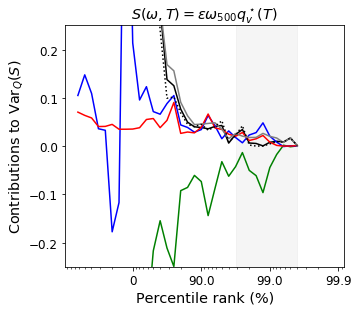

In [203]:
%%time 
print()
print("> plot variance and corresponding contributions")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))

ax.set_ylim((-0.25,0.25))

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,Q_IL,i_Q_lims,alpha=0.15,transformX=False)


# subplotRanksILog(ax,ranks,np.zeros(ranks.shape),ltype=':',col='k')
subplotRanksILog(ax,ranks,
                 norm_var_pr_sc2_prQ,
                 col='k',ltype='-',transformX=False)

subplotRanksILog(ax,ranks,
                 all_contribs_var,
                 col=['green','blue','red','grey','k'],ltype=['-','-','-','-',':'],transformX=True)

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel(r'Contributions to Var$_Q(S)$')
ax.set_title(r'$S(\omega,T)=\varepsilon\omega_{500}q_v^\star(T)$')

# ax.legend([r'$\alpha_1 Var(T)$',r'$\alpha_2 Cov(T,\omega)$',r'$\alpha_3 Var(\omega)$','sum'])

plt.show()
print()